Install Packages, create dataframe, and perform feature engineering and selection

Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
You supplied CategoryEncoder = 
Skipping category encoding since no categor

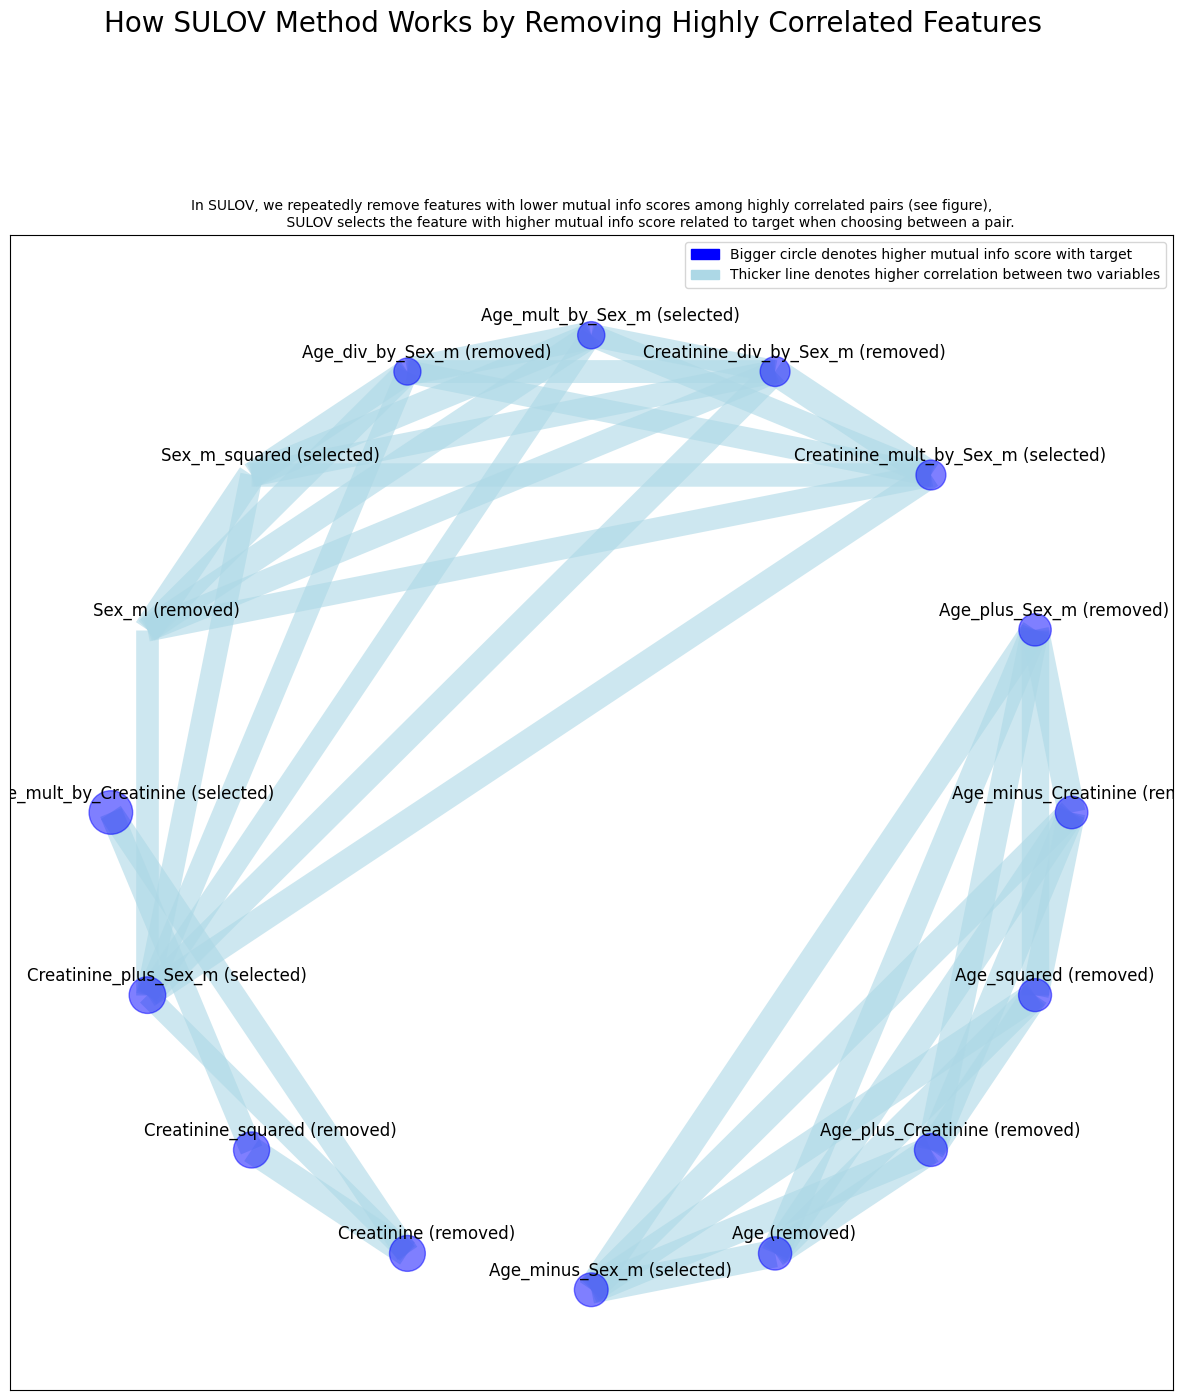

Time taken for SULOV method = 3 seconds
    Adding 0 categorical variables to reduced numeric variables  of 8
Final list of selected 8 vars after SULOV = ['Age_div_by_Creatinine', 'Creatinine_minus_Sex_m', 'Age_mult_by_Creatinine', 'Creatinine_plus_Sex_m', 'Age_minus_Sex_m', 'Creatinine_mult_by_Sex_m', 'Age_mult_by_Sex_m', 'Sex_m_squared']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since ['interactions'] category encoding is done, dropping original categorical vars from predictors...
    Taking top 2 features per iteration...
    Number of booster rounds = 100
        Selected: ['Age_mult_by_Creatinine', 'Age_div_by_Creatinine']
        Selected: ['Age_mult_by_Creatinine', 'Age_mi

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model, load_model
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from featurewiz import featurewiz
from keras_tuner import Hyperband, Objective

data = pd.read_excel('C:\GFR Project\gfrvalues.xlsx').dropna()
X = data[['Sex', 'Age', 'Creatinine']]
y = data['GFR'].values

#OneHotEncoding Sex
X['Sex'] = X['Sex'].str.lower()
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)

data = X.copy()
data['GFR'] = y

target = 'GFR'


#Feature Engineering
train, test = train_test_split(data, test_size=0.2, random_state=42)


train_df_transformed, test_df_transformed = featurewiz(train, target, corr_limit=0.7, verbose=1,
                                                       test_data=test,
                                                       feature_engg=['interactions'],
                                                       CategoryEncoder='')


X_train_fw = train_df_transformed.drop(columns=[target])
y_train_fw = train_df_transformed[target]

X_test_fw = test_df_transformed


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_fw)
X_test_scaled = scaler.transform(X_test_fw)


print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print(f"X_train_scaled: {X_train_scaled}")
print(f"X_test_scaled: {X_test_scaled}")



Model Hyperparameter Tuning

In [ ]:
#Hyperparameter tuning
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def model_builder(hp):
    model = Sequential()
    model.add(Dense(5, input_dim=X_train_scaled.shape[1]))

    hp_activation = hp.Choice('activation', values=['leaky_relu'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=64, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=64, step=1)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if hp_activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(tf.keras.layers.Activation(hp_activation))

    model.add(Dense(units=hp_layer_1))

    if hp_activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(tf.keras.layers.Activation(hp_activation))

    model.add(Dense(units=hp_layer_2))

    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=root_mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    return model


tuner = Hyperband(model_builder,
                     objective=Objective("val_rmse", direction="min"),
                     max_epochs=50,
                     factor=3,
                     overwrite=True)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(X_train_scaled, y_train_fw, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 90 Complete [00h 00m 12s]
val_rmse: 24.250444412231445

Best val_rmse So Far: 13.479283332824707
Total elapsed time: 00h 08m 44s


Print Best Hyperparameters

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"Best Hyperparameters:")
print(f" - Activation: {best_hps.get('activation')}")
print(f" - Layer 1 units: {best_hps.get('layer_1')}")
print(f" - Layer 2 units: {best_hps.get('layer_2')}")
print(f" - Learning rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - Activation: leaky_relu
 - Layer 1 units: 36
 - Layer 2 units: 41
 - Learning rate: 0.01


In [ ]:
y_test = test['GFR']

Fitting the model on the test set; calculating RMSE and accuracy

In [ ]:
#Fit the model on the test set
model = tuner.hypermodel.build(best_hps)


history = model.fit(X_train_scaled, y_train_fw, epochs=100, batch_size=16, validation_split=0.2, callbacks=[stop_early])

y_pred = model.predict(X_test_scaled).flatten()
rmse_value = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse_value}')

accuracy_range_upper_test = y_test * 1.3
accuracy_range_lower_test = y_test * 0.7
within_accuracy_range_test = np.sum((y_pred >= accuracy_range_lower_test) & (y_pred <= accuracy_range_upper_test))
total_samples_test = len(y_test)
percentage_within_accuracy_range_test = (within_accuracy_range_test / total_samples_test) * 100
print(f'Percentage of predicted values within 30% of true values on Test Set: {percentage_within_accuracy_range_test:.2f}%')



Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 74.2766 - rmse: 75.5661 - val_loss: 28.3441 - val_rmse: 28.6816
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.4574 - rmse: 27.7293 - val_loss: 24.6319 - val_rmse: 24.9395
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.2618 - rmse: 23.5970 - val_loss: 20.4112 - val_rmse: 20.7896
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.3408 - rmse: 17.6799 - val_loss: 16.4962 - val_rmse: 17.0322
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.8832 - rmse: 16.2917 - val_loss: 13.2736 - val_rmse: 13.5933
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.7119 - rmse: 13.1635 - val_loss: 13.5504 - val_rmse: 13.7914
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8787 - rmse: 13.1322 - val_loss: 14.7592 - val_rmse: 15.1437
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.8620 - rmse: 12.1715 - val_loss: 12.8459 - val_rmse: 13.2519
Epoch 9/100
35/

Producing accuracy and residual plots for the model's performance on the test set

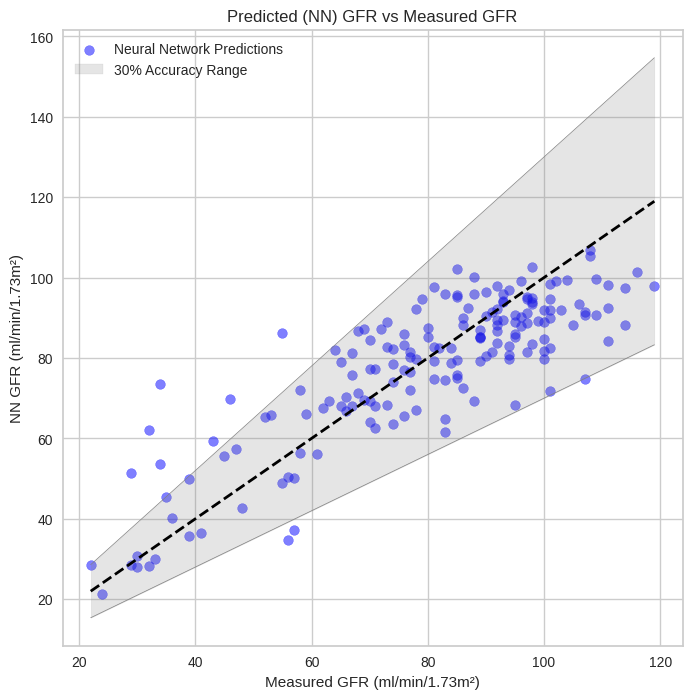

Percentage of predicted values within 30% of true values on Test Set: 94.22%
Mean Bias: -1.4979773394634268
Median Bias: -2.50323486328125


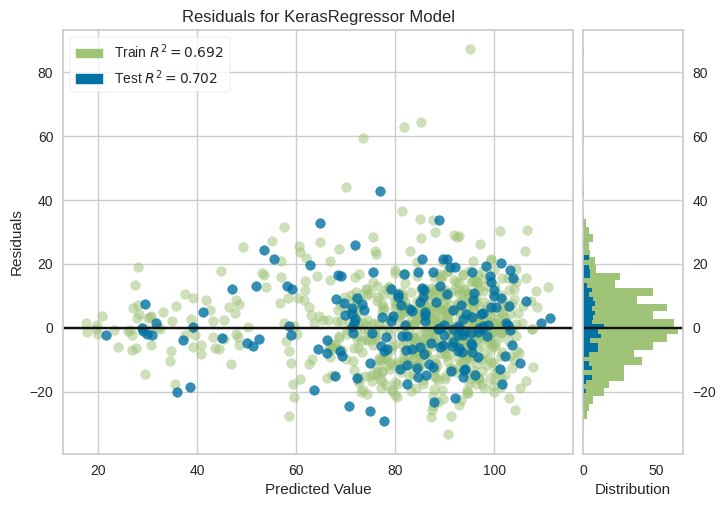

Training R2 Score: 0.6917845985566282
Test R2 Score: 0.7023075473465333
R2 Score Difference: -0.010522948789905118


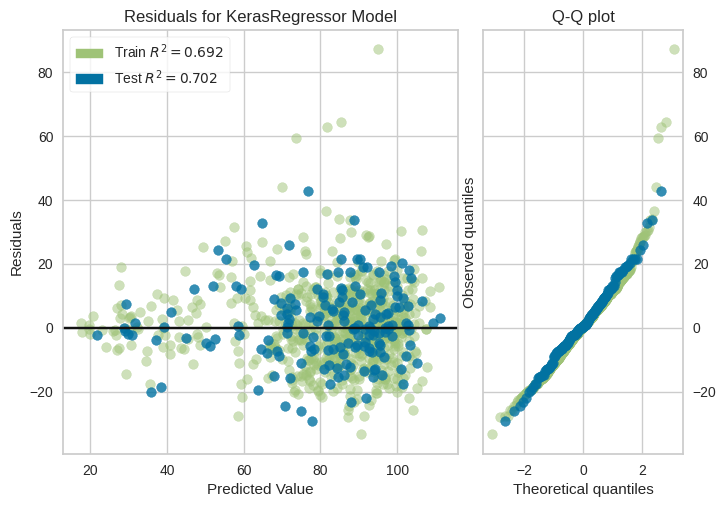

In [ ]:
from yellowbrick.regressor import ResidualsPlot, residuals_plot, prediction_error
#Accuracy and residual plots
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Neural Network Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=2)

x_range = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_range, 1.3 * x_range, color='gray', linestyle='-', linewidth=0.5)
plt.plot(x_range, 0.7 * x_range, color='gray', linestyle='-', linewidth=0.5)
plt.fill_between(x_range, 0.7 * x_range, 1.3 * x_range, color='gray', alpha=0.2, label='30% Accuracy Range')
plt.title('Predicted (NN) GFR vs Measured GFR')
plt.xlabel('Measured GFR (ml/min/1.73m\u00b2)')
plt.ylabel('NN GFR (ml/min/1.73m\u00b2)')

plt.legend()

plt.show()

accuracy_range_upper_test = y_test * 1.3
accuracy_range_lower_test = y_test * 0.7
within_accuracy_range_test = np.sum((y_pred >= accuracy_range_lower_test) & (y_pred <= accuracy_range_upper_test))
total_samples_test = len(y_test)
percentage_within_accuracy_range_test = (within_accuracy_range_test / total_samples_test) * 100
print(f'Percentage of predicted values within 30% of true values on Test Set: {percentage_within_accuracy_range_test:.2f}%')

meanbias = np.mean((y_pred-y_test))
print(f'Mean Bias: {meanbias}')

medianbias = np.median((y_pred -y_test))
print(f'Median Bias: {medianbias}')

keras_regressor = KerasRegressor(model=model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

keras_regressor.fit(X_train_scaled, y_train_fw)


def res_hist_plot(model, X_train_scaled, y_train_fw, X_test_scaled, y_test):
    res_plt = ResidualsPlot(model, train_alpha=0.5, test_alpha=0.8,
                            train_color="g", test_color="b", is_fitted=True)
    res_plt.fit(X_train_scaled, y_train_fw)
    res_plt.score(X_test_scaled, y_test)
    hist_plot = res_plt.show()
    train_r2score = res_plt.train_score_
    test_r2score = res_plt.test_score_
    r2score_diff = train_r2score - test_r2score
    return hist_plot, train_r2score, test_r2score, r2score_diff


def res_qq_plot(model, X_train_scaled, y_train_fw, X_test_scaled, y_test):
    res_plt = ResidualsPlot(model, train_alpha=0.5, test_alpha=0.8,
                            train_color="g", test_color="b", is_fitted=True,
                            hist=False, qqplot=True)
    res_plt.fit(X_train_scaled, y_train_fw)
    res_plt.score(X_test_scaled, y_test)
    qq_plt = res_plt.show()
    return qq_plt


model_res_hist_plot, model_train_r2score, model_test_r2score, model_r2score_diff = res_hist_plot(keras_regressor,
                                                                                     X_train_scaled,
                                                                                     y_train_fw,
                                                                                     X_test_scaled,
                                                                                     y_test)
print(f"Training R2 Score: {model_train_r2score}")
print(f"Test R2 Score: {model_test_r2score}")
print(f"R2 Score Difference: {model_r2score_diff}")


model_res_qq_plot = res_qq_plot(keras_regressor, X_train_scaled, y_train_fw, X_test_scaled, y_test)